# Flux and Elementary Mode Analysis for L-DOPA Synthesis

## Imports

In [1]:
#load up everything
%matplotlib inline
import cobra
from cobra import Model, Reaction, Metabolite
cobra_config = cobra.Configuration()
import escher
from escher import Builder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
import cobra.test
from cobra.flux_analysis import (
    single_gene_deletion, single_reaction_deletion, double_gene_deletion,double_reaction_deletion)

network = pd.read_csv('shikimate_reactions.csv' , header=0)#shikimate related reactions to add
sinks = pd.read_csv('sinks.csv' , header=0)#sinks to add

levdopa_synthesis = cobra.io.load_json_model("e_coli_core.json")#e coli central metabolism model from BiGG
#levdopa_synthesis.solver = 'cplex'

#define intracellular reactions not in central metabolism model
for (myenzyme , mypathway , myreaction) in network.itertuples(index = False):
    rxn = Reaction(myenzyme)
    levdopa_synthesis.add_reactions([rxn])
    rxn.name = myenzyme
    rxn.subsystem = mypathway
    rxn.build_reaction_from_string(myreaction)

#define extra transport reactions not in central metabolism model
for (mymetabolite , mydirection) in sinks.itertuples(index = False):
    myreaction = '%s -->' % mymetabolite
    rxn = Reaction('EX_%s' % mymetabolite)
    levdopa_synthesis.add_reactions([rxn])
    rxn.subsystem = 'Extracellular exchange'
    rxn.name = '%s_transport' % mymetabolite
    rxn.build_reaction_from_string(myreaction)
    rxn.lower_bound = 0.
    rxn.upper_bound = 1000.

unknown metabolite 'dahp_c' created
unknown metabolite 'dhq_c' created
unknown metabolite '3dhs_c' created
unknown metabolite 'shikimate_c' created
unknown metabolite 'shikimate3p_c' created
unknown metabolite 'epsp_c' created
unknown metabolite 'chorismate_c' created
unknown metabolite 'prephenate_c' created
unknown metabolite '4hppa_c' created
unknown metabolite 'tyr__L_c' created
unknown metabolite 'levdopa_c' created
unknown metabolite 'levdopa_e' created


## FBA

Glucose is the carbon source here. Nitrogen is assimilated from ammonia using GLUDy. This growth is aerobic, which provides the ATP needed for synthetic activities and closes the redox balance. 

In [2]:
levdopa_synthesis.objective = 'EX_levdopa_e'#maximize L-DOPA production

builder = Builder(map_json = 'full_map.json')#based around corresponding BiGG map. I added shikimate stuff.
builder.model = levdopa_synthesis
builder.highlight_missing = True

solution = builder.model.optimize()

builder.reaction_data = solution.fluxes/ abs(solution['EX_glc__D_e'])

Y_ldopa_glc = solution['EX_levdopa_e']/abs(solution['EX_glc__D_e'])
Y_ldopa_nh4 = solution['EX_levdopa_e']/abs(solution['EX_nh4_e'])

print('Yield of levdopa from glucose: %f mol/mol; %f cmol/cmol' % (Y_ldopa_glc , 9/6*Y_ldopa_glc))
print('Yield of levdopa from ammonia: %f mol/mol' % Y_ldopa_nh4)

builder

Yield of levdopa from glucose: 0.508230 mol/mol; 0.762345 cmol/cmol
Yield of levdopa from ammonia: 1.000000 mol/mol


Builder(highlight_missing=True, reaction_data={'PFK': 0.8305899280575539, 'PFL': 0.0, 'PGI': 1.0, 'PGK': -1.32…

## FBA, but with Glutamate+Glucose as a Feedstock

In [3]:
import copy
levdopa_synthesis_with_glutamate = copy.deepcopy(levdopa_synthesis)

#allow glutamate to be used as a feedstock
levdopa_synthesis_with_glutamate.reactions.EX_glu__L_e.lower_bound = -1000

builder_glutamate = Builder(map_json = 'full_map.json')#based around corresponding BiGG map. I added shikimate stuff.
builder_glutamate.model = levdopa_synthesis_with_glutamate
builder_glutamate.highlight_missing = True

solution_glutamate = builder_glutamate.model.optimize(objective_sense = None)
builder_glutamate.reaction_data = solution_glutamate.fluxes / abs(solution_glutamate['EX_glc__D_e'])

Y_ldopa_glc = solution_glutamate['EX_levdopa_e']/abs(solution_glutamate['EX_glc__D_e'])
Y_ldopa_glu = solution_glutamate['EX_levdopa_e']/abs(solution_glutamate['EX_glu__L_e'])
pct_carbon_assimilated = solution_glutamate['EX_levdopa_e'] * 9 / abs(solution_glutamate['EX_glc__D_e'] * 6 + solution_glutamate['EX_glu__L_e'] * 5) * 100

print('Yield of levdopa from glucose: %f mol/mol; %f cmol/cmol' % (Y_ldopa_glc , 9/6*Y_ldopa_glc))
print('Yield of levdopa from glutamate: %f mol/mol; %f cmol/cmol' % (Y_ldopa_glu , 9/5*Y_ldopa_glu))
print('Percent of carbon from both glucose and glutamate into L-DOPA: %f%%' % pct_carbon_assimilated)

builder_glutamate

Yield of levdopa from glucose: 15.442448 mol/mol; 23.163672 cmol/cmol
Yield of levdopa from glutamate: 0.312127 mol/mol; 0.561829 cmol/cmol
Percent of carbon from both glucose and glutamate into L-DOPA: 54.852494%


Builder(highlight_missing=True, reaction_data={'PFK': 0.0, 'PFL': 48.4244776119403, 'PGI': 1.0, 'PGK': 18.5899…

## Anaerobic Flux Balance Analysis

In [4]:
levdopa_synthesis_anaerobic = copy.deepcopy(levdopa_synthesis)

#knock out oxygen intake
levdopa_synthesis_anaerobic.reactions.O2t.knock_out()

builder_anaerobic = Builder(map_json = 'full_map.json')#based around corresponding BiGG map. I added shikimate stuff.
builder_anaerobic.model = levdopa_synthesis_anaerobic
builder_anaerobic.highlight_missing = True

solution_anaerobic = builder_anaerobic.model.optimize(objective_sense = None)
builder_anaerobic.reaction_data = solution_anaerobic.fluxes / abs(solution_anaerobic['EX_glc__D_e'])

Y_ldopa_glc = solution_anaerobic['EX_levdopa_e']/abs(solution_anaerobic['EX_glc__D_e'])
Y_ldopa_nh4 = solution_anaerobic['EX_levdopa_e']/abs(solution_anaerobic['EX_nh4_e'])

print('Yield of levdopa from glucose: %f mol/mol; %f cmol/cmol' % (Y_ldopa_glc , 9/6*Y_ldopa_glc))
print('Yield of levdopa from ammonia: %f mol/mol' % Y_ldopa_nh4)


builder_anaerobic

Yield of levdopa from glucose: -0.000000 mol/mol; -0.000000 cmol/cmol
Yield of levdopa from ammonia: nan mol/mol


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14 RuntimeWarning: invalid value encountered in double_scalars


Builder(highlight_missing=True, reaction_data={'PFK': 1.0000000000000002, 'PFL': 0.0, 'PGI': 1.000000000000000…

## Save FBA Results

In [5]:
s = pd.DataFrame(solution.fluxes).query('fluxes != 0')
s_g = pd.DataFrame(solution_glutamate.fluxes).query('fluxes != 0')
s_a = pd.DataFrame(solution_anaerobic.fluxes).query('fluxes != 0')
s.to_csv('FBA_results/aerobic.csv')
s_g.to_csv('FBA_results/aerobic_glutamate.csv')
s_a.to_csv('FBA_results/anaerobic.csv')

## Elementary Flux Mode Analysis

In [9]:
from cobamp.wrappers import KShortestEFMEnumeratorWrapper

#Cobamp was freaking out about the BiGG model having too much complexity in its gene modeling.
#Go ahead and scrub the gene data, since we aren't particularly interested for this analysis anyway.
for rxn in levdopa_synthesis_with_glutamate.reactions:
    rxn.gene_reaction_rule = ''

#Define KShortestEFM algorithm to run
ksefm = KShortestEFMEnumeratorWrapper(
    model=levdopa_synthesis_with_glutamate,
    non_consumed=[],
    consumed=['glu__L_e'],
    produced=['levdopa_e'],#Limit to any EFMs that can produce L-DOPA
    algorithm_type=KShortestEFMEnumeratorWrapper.ALGORITHM_TYPE_POPULATE,
    stop_criteria=200,#Limit max size for an EFM to 100 reactions
    solver='CPLEX'
)

#Run KShortestEFM algorithm
enumerator = ksefm.get_enumerator()
efm_list = []
while len(efm_list) == 0:
    efm_list += next(enumerator)

/Applications/anaconda3/lib/python3.7/site-packages/cobamp/wrappers/external_wrappers.py:271 UserWarning: Will not normalize rules with more than 20 average tokens per gene


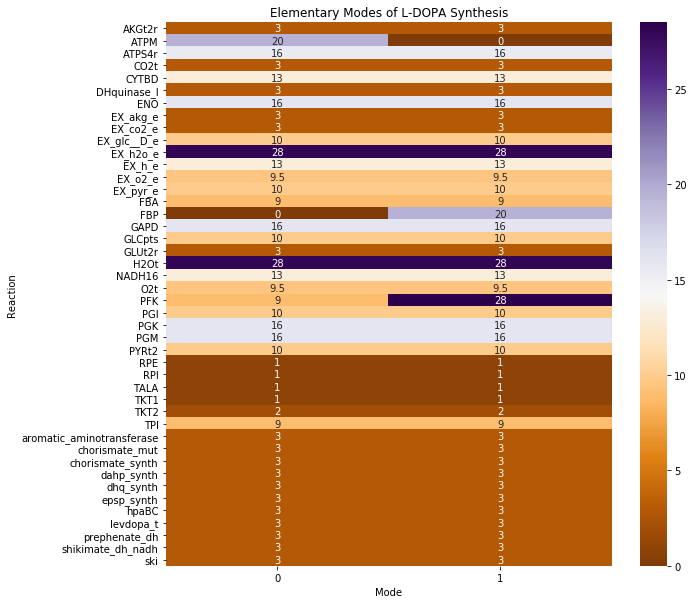

In [7]:
#Heatmap EFMs
def normalize_flux_vector(row):
    row2 = np.abs(row)
    row2 = row[row>0]
    min_flux = row2.min()
    return row/min_flux

import seaborn as sns
emdf = pd.DataFrame(efm_list).T
emdf.fillna(0, inplace = True)
emdf = emdf.apply(normalize_flux_vector, axis = 0)
emdf = emdf.sort_index()
#emdf.columns = ['em%i' % i for i in range(0 , emdf.shape[0] + 1)]
plt.rcParams['figure.figsize'] = [10, 10]
sns.heatmap(np.abs(emdf) , cmap='PuOr' , annot = True);
plt.title('Elementary Modes of L-DOPA Synthesis');
plt.ylabel('Reaction');
plt.xlabel('Mode');

In [8]:
#Display results as an interactive Escher diagram
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def plotEFM(x):
    builder_efm = Builder(map_json = 'full_map.json')
    builder_efm.reaction_data = efm_list[x]
    builder_efm.hide_secondary_metabolites = True
    return builder_efm

interact(plotEFM, x=widgets.IntSlider(min=0, max=len(efm_list)-1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='x', max=1), Output()), _dom_classes=('widget-interact',)…